# Experiments

The goal of this notebook is to implement different components of the agent to understand how they should be implemented.

In [37]:
# Import libraries
import os
import logging
from enum import Enum
from pydantic import BaseModel, Field
from typing import Annotated, Dict, List, Optional, Union, Literal, Any

from IPython.display import Image, display
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langchain_core.prompts import PromptTemplate
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, START, END, add_messages
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage

from src.config.settings import settings

In [2]:
# Set langsmith project
os.environ["LANGSMITH_API_KEY"] = settings.langsmith_api_key.get_secret_value()
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = settings.app_name

# Suppress all debug logs from urllib3 and langsmith
logging.getLogger("urllib3").setLevel(logging.WARNING)
logging.getLogger("langsmith").setLevel(logging.WARNING)
logging.getLogger("openai._base_client").setLevel(logging.WARNING)
logging.getLogger("openai._base_client").setLevel(logging.WARNING)
logging.getLogger("httpcore").setLevel(logging.WARNING)
logging.getLogger("httpx").setLevel(logging.WARNING)
logging.getLogger("websockets.client").setLevel(logging.WARNING)
logging.getLogger("pyppeteer").setLevel(logging.WARNING)

---
## Audience Research Agent

This agent transforms generic demographics to deep psychological profile. It extracts core values, daily routines, behavioral patterns, pain points, emotional triggers, and decision-making process.

In [3]:
# State
class CampaignGoal(str, Enum):
    """Possible objectives for an advertising campaign"""
    AWARENESS = 'awareness'
    TRAFFIC = 'traffic'
    ENGAGEMENT = 'engagement'
    LEADS = 'leads'
    APP_INSTALLS = 'app installs'


class AdPlatform(str, Enum):
    """Specific ad placements across different social platforms"""
    INSTAGRAM_REELS = "instagram_reels"
    INSTAGRAM_STORY = "instagram_video_story"
    FACEBOOK_FEEDS = "facebook_feed"
    FACEBOOK_STORY = "facebook_story"
    YOUTUBE_SHORT = "youtube_short"
    TIKTOK_REELS = "tiktok_reels"


class AudienceGender(str, Enum):
    """
    Gender identity options for the target audience.
    """
    MALE = "male"
    FEMALE = "female"
    ALL = "male and female"


class AudienceLocation(str, Enum):
    """
    Location options for the target audience.
    """
    USA = "united states"
    UK = "united kingdom"
    CANADA = "canada"
    AUSTRALIA = "australia"


class AudienceIncomeRange(str, Enum):
    """
    Income range categories for audience segmentation.
    """
    LOW = "<$30k"
    LOWER_MIDDLE = "$30k–$60k"
    MIDDLE = "$60k–$100k"
    UPPER_MIDDLE = "$100k–$200k"
    HIGH = ">$200k"


class AudienceAgeRange(BaseModel):
    min_age: int = Field(
        ...,
        description="Minimum age for the target audience"
    )
    max_age: int = Field(
        ...,
        description="Maximum age for the target audience"
    )


class ProductPlatform(str, Enum):
    """Mobile platforms supported by the product."""
    ios = "ios"
    android = "android"
    web="web"


class Product(BaseModel):
    """Product information"""
    name: str = Field(
        ...,
        description="Name of the product"
    )
    description: str = Field(
        ...,
        description="A brief overview of the product"
    )
    features: Dict[str, str] = Field(
        ...,
        description="Dictionary mapping feature names to their description"
    )
    supported_platforms: List[ProductPlatform] = Field(
        ...,
        description="Supported platforms for the application"
    )

In [4]:
# Audience researcher output schema
class AudienceProfile(BaseModel):
    core_values: List[str] = Field(
        ...,
        description="The audience’s fundamental beliefs and priorities (e.g., privacy, convenience, achievement)."
    )
    daily_routines: List[str] = Field(
        ...,
        description="Typical daily habits, recurring activities, or schedules common for this audience."
    )
    behavioral_patterns: List[str] = Field(
        ...,
        description="Frequent actions and tendencies in digital, social, or shopping behaviors."
    )
    pain_points: List[str] = Field(
        ...,
        description="Persistent frustrations, challenges, and unmet needs or desires for this group."
    )
    emotional_triggers: List[str] = Field(
        ...,
        description="Words, scenarios, or experiences that evoke strong emotions or reactions."
    )
    decision_process: List[str] = Field(
        ...,
        description="Typical steps, questions, and criteria used by the audience to make product or app choices."
    )
    summary: Optional[str] = Field(
        ...,
        description="Brief natural language summary highlighting the overall persona and mindset."
    )

In [7]:
class GraphState(BaseModel):
    messages: Annotated[List[AnyMessage], add_messages] = Field(
        [],
        description="Messages for audience research agent"
    )
    campaign_goal: CampaignGoal = Field(
        ...,
        description="Goal of the marketing campaign"
    )
    ad_platform: AdPlatform = Field(
        ...,
        description="Platform for the advertisement"
    )
    audience_gender: AudienceGender = Field(
        ...,
        description="Gender of the target audience"
    )
    audience_location: AudienceLocation = Field(
        ...,
        description="Location of the target audience"
    )
    audience_income_range: AudienceIncomeRange = Field(
        ...,
        description="Income range for the target audience"
    )
    audience_age_range: AudienceAgeRange = Field(
        ...,
        description="Age range for the target audience"
    )
    audience_interests: Optional[List[str]] = Field(
        None,
        description="List of interests for the target audience"
    )
    product_details: Product = Field(
        ...,
        description="Details about the product"
    )
    audience_profile: Optional[AudienceProfile] = Field(
        None,
        description="Result of audience researcher"
    )


In [8]:
# Prompts
audience_research_system_message = PromptTemplate(
    template="""You are an expert audience researcher, specialized in transforming basic demographics into rich psychological profiles for ad copywriting teams. Your job is to discover actionable insights about the audience’s core values, daily routines, behavioral patterns, pain points, emotional triggers, and decision-making processes.

You have access to a websearch tool. The effectiveness of your research depends on crafting intelligent, targeted search queries—this is critical for high-quality results.

You may use the search tool up to 5 times per task. Plan your queries carefully to maximize relevance and depth.

**Goal:**
Based on your findings, fill out every field of the AudienceProfile schema with clear, evidence-based information. Favor concise, actionable lists and summaries that copywriters can use directly.

**Instructions:**
- Start by reviewing the context provided by the user about the campaign and audience.
- For each insight required (values, routines, patterns, pain points, emotional triggers, decision steps), create focused search queries and process results.
- Synthesize your findings; do not copy/paste raw information from the web—always interpret and rephrase for clarity and usefulness.
- Limit websearch tool calls to 5; prioritize quality over quantity.

**Output Schema:**
return your answer strictly using the 'build_audience_profile' tool.
"""
)

audience_research_user_message = PromptTemplate(
    input_variables=["campaign_goal", "ad_platform", "audience_gender", "audience_location", "audience_income_range", "audience_age_range", "audience_interests", "product_details", "product_platform"],
    template="""Here is the context for your audience research task. Use these details to guide your information gathering and ensure your psychological profile is highly relevant.

- **Campaign Goal:** {campaign_goal}
- **Ad Platform:** {ad_platform}
- **Audience Gender:** {audience_gender}
- **Audience Location:** {audience_location}
- **Audience Income Range:** {audience_income_range}
- **Audience Age Range:** {audience_age_range}
- **Audience Interests:** {audience_interests}
- **Product Platform:** {product_platform}

**Product(Digital Service) Details:**
Name: {product_details.name}
Description: {product_details.description}
Features: {product_details.features}
Supported Platforms: {product_details.supported_platforms}
"""
)

In [9]:
# Create LLM and bind tool
llm = ChatOpenAI(api_key=settings.open_ai_api_key.get_secret_value(), model="gpt-4o")

In [10]:
# Create the search tool
search_tool = TavilySearch(tavily_api_key=settings.tavily_api_key.get_secret_value(), max_results=3)

In [17]:
# Nodes
def audience_research_node(state: GraphState):
    messages = state.messages
    campaign_goal = state.campaign_goal
    ad_platform = state.ad_platform
    audience_gender = state.audience_gender
    audience_location = state.audience_location
    audience_income_range = state.audience_income_range
    audience_age_range = state.audience_age_range
    audience_interests = state.audience_interests if state.audience_interests is not None else []
    product_details = state.product_details
    product_platform = product_details.supported_platforms

    # Bind tools to the LLM
    llm_with_tools = llm.bind_tools([search_tool])
    # Specify the structured output

    # Create prompt
    system_message = SystemMessage(content=audience_research_system_message.format())
    user_message = HumanMessage(content=audience_research_user_message.format(campaign_goal=campaign_goal, ad_platform=ad_platform, audience_gender=audience_gender, audience_location=audience_location, audience_income_range=audience_income_range, audience_age_range=audience_age_range, audience_interests=audience_interests, product_details=product_details, product_platform=product_platform))

    # Create messages
    if len(messages) == 0:
        messages.append(system_message)
        messages.append(user_message)

    ai_message = llm_with_tools.invoke(messages)
    print(ai_message)

    return {"audience_profile": getattr(ai_message, "content", ai_message), "messages": messages}


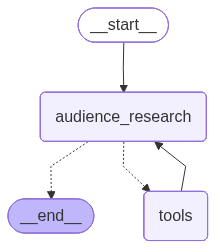

In [18]:
# Graph
audience_research_builder = StateGraph(GraphState)

audience_research_builder.add_node("audience_research", audience_research_node)
audience_research_builder.add_node("tools", ToolNode([search_tool]))

audience_research_builder.add_edge(START, "audience_research")
audience_research_builder.add_conditional_edges("audience_research", tools_condition)
audience_research_builder.add_edge("tools", "audience_research")

memory = InMemorySaver()
audience_research_agent = audience_research_builder.compile(checkpointer=memory)

display(Image(audience_research_agent.get_graph().draw_mermaid_png()))

In [19]:
thread = {"configurable": {"thread_id": 1}}
initial_state = GraphState(
    campaign_goal=CampaignGoal.AWARENESS,
    ad_platform=AdPlatform.INSTAGRAM_REELS,
    audience_gender=AudienceGender.ALL,
    audience_location=AudienceLocation.USA,
    audience_income_range=AudienceIncomeRange.LOWER_MIDDLE,
    audience_age_range=AudienceAgeRange(min_age=25, max_age=35),
    product_details=Product(
        name="Delisio- Your Personal Chef",
        description="Delisio is a personal chef and nutrition assistant. When a user signs up, they enter their age, weight, height, diet (e.g., vegan, keto), nutritional goal (e.g., weight loss, muscle gain), allergies, and equipments. Delisio then provides personalized recipes based on their preferences and taste preferences and uses AI to personalize user food experience",
        features={
            "Photo to Recipe": "Photo to Recipe: User uploads a photo of any dish, specify equipments, define calorie preference, and Delisio generates a personalized recipe tailored to their preferences",
            "Surprise Me": "User selects meal type, cuisine, specify equipments, define calorie preference; Delisio generates a unique, personalized recipe (e.g., a vegetarian Chinese breakfast)",
            "Nutrition Scanner": "User scans their food; Delisio analyzes and reports nutrients, vitamins, and minerals.",
        },
        supported_platforms=[ProductPlatform.ios, ProductPlatform.android]
    ),
)

In [20]:
for event in audience_research_agent.stream(initial_state, config=thread, stream_mode="updates"):
    print(event)

content='' additional_kwargs={'tool_calls': [{'id': 'call_tyX46VbaSiOgZPBPID0VxDjs', 'function': {'arguments': '{"query": "core values of American young adults aged 25-35 lower-middle income", "search_depth": "advanced"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'call_rhcyIIBGtcBS4RPMAPJAbQrF', 'function': {'arguments': '{"query": "daily routines of American young adults aged 25-35 lower-middle income", "search_depth": "advanced"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 1870, 'total_tokens': 1954, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f64f290af2', 'id': 'chatcmpl-CPsYQbzNbRZC1DFJSgm0kLvOadh2m', 'service_tier': 'default', 'finish_reason': 'tool_c

ValidationError: 1 validation error for GraphState
audience_profile
  Input should be a valid dictionary or instance of AudienceProfile [type=model_type, input_value='', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/model_type